In [4]:
import numpy as np
import pyspark
from pyspark.context import SparkContext
from pyspark.mllib.regression import LabeledPoint
sc = SparkContext('local', 'test')

23/05/15 17:29:38 WARN Utils: Your hostname, Hays-MacBook.local resolves to a loopback address: 127.0.0.1; using 10.89.205.149 instead (on interface en0)
23/05/15 17:29:38 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/05/15 17:29:38 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
23/05/15 17:29:39 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
/Users/LuMiNaE/Library/Python/3.7/lib/python/site-packages/pyspark/context.py:317: FutureWarning: Python 3.7 support is deprecated in Spark 3.4.
  warnings.warn("Python 3.7 support is deprecated in Spark 3.4.", FutureWarning)


In [5]:
data = sc.textFile('./data/WildBlueberryPollinationSimulationData.csv')
header = data.first() #extract header
data = data.filter(lambda row: row != header)

In [4]:
print(data.take(1)[0])

len(data.take(1)[0].split(","))

print(data.take(1)[0].split(",")[18-1])
print(data.take(1)[0].split(",")[1:18-1])

0,37.5,0.75,0.25,0.25,0.25,86,52,71.9,62,30,50.8,16,0.26,0.410652063,0.408159008,31.67889844,3813.165795
3813.165795
['37.5', '0.75', '0.25', '0.25', '0.25', '86', '52', '71.9', '62', '30', '50.8', '16', '0.26', '0.410652063', '0.408159008', '31.67889844']


In [5]:
def parsePoint(line):
    string = line.split(",")
    return LabeledPoint(string[len(string)-1], string[1:len(string)-1])

parsedData = data.map(parsePoint)

In [6]:
weights = [.8, .1, .1]
seed = 42
preTrainData, preValData, preTestData = parsedData.randomSplit(weights, seed)
nTrain = preTrainData.count()
nVal = preValData.count()
nTest = preTestData.count()

print(nTrain, nVal, nTest, nTrain + nVal + nTest)
print(data.count())

620 77 80 777
777


In [7]:
print(preTrainData.collect()[0])
len(preTrainData.collect()[0].features)

(3813.165795,[37.5,0.75,0.25,0.25,0.25,86.0,52.0,71.9,62.0,30.0,50.8,16.0,0.26,0.410652063,0.408159008,31.67889844])


16

In [9]:
def squaredError(label, prediction):
    return (float(label)-float(prediction))**2

def calcRMSE(labelsAndPreds):
    se = labelsAndPreds.map(lambda x: squaredError(x[0], x[1])).collect()
    return np.sqrt(np.mean(se))

In [10]:
averageLabel = preTrainData.map(lambda x: x.label).mean()
averageLabelsd = preTrainData.map(lambda x: x.label).stdev()
print(averageLabel)
print(averageLabelsd)

averageFeatmu = [0 for i in range(16)]
averageFeatsd = [0 for i in range(16)]
for i in range(16):
    averageFeatmu[i] = preTrainData.map(lambda x: x.features[i]).mean()
    averageFeatsd[i] = preTrainData.map(lambda x: x.features[i]).stdev()

print(averageFeatmu)
print(averageFeatsd)

6023.576023548384
1370.8607608856885
[18.98387096774191, 0.4396370967741939, 0.28371612903225835, 0.4648887096774193, 0.5603967741935483, 82.02774193548395, 49.5638709677419, 68.52403225806455, 59.127741935483876, 28.606129032258057, 48.47338709677413, 18.152000000000005, 0.31822580645161297, 0.5024662324225811, 0.44613384592580685, 36.14500115696773]
[6.974589675718638, 1.0919827064585201, 0.06602460487978512, 0.15868086923011657, 0.1669678662997493, 9.100937814021863, 5.530707635655008, 7.601261771251428, 6.579415950977969, 3.177784963409774, 5.362193052662974, 12.21095425189758, 0.17208235269260072, 0.08036996388852397, 0.040984418422534315, 4.4394141766364354]


In [11]:
TrainData = preTrainData.map(lambda x: LabeledPoint((x.label-averageLabel)/averageLabelsd,
                                        [(x.features[i]-averageFeatmu[i])/averageFeatsd[i] for i in range(16)]))
ValData = preValData.map(lambda x: LabeledPoint((x.label-averageLabel)/averageLabelsd,
                                        [(x.features[i]-averageFeatmu[i])/averageFeatsd[i] for i in range(16)]))
TestData = preTestData.map(lambda x: LabeledPoint((x.label-averageLabel)/averageLabelsd,
                                        [(x.features[i]-averageFeatmu[i])/averageFeatsd[i] for i in range(16)]))

TrainData.cache()
ValData.cache()
TestData.cache()

labelsAndPredsTrain = TrainData.map(lambda x: (x.label, 0))
rmseTrainBase = calcRMSE(labelsAndPredsTrain)

labelsAndPredsVal = ValData.map(lambda x: (x.label, 0))
rmseValBase = calcRMSE(labelsAndPredsVal)

labelsAndPredsTest = TestData.map(lambda x: (x.label, 0))
rmseTestBase = calcRMSE(labelsAndPredsTest)

print('Baseline Train RMSE = {0:.3f}'.format(rmseTrainBase))
print('Baseline Validation RMSE = {0:.3f}'.format(rmseValBase))
print('Baseline Test RMSE = {0:.3f}'.format(rmseTestBase))

Baseline Train RMSE = 1.000
Baseline Validation RMSE = 0.955
Baseline Test RMSE = 0.936


In [12]:
TrainData.collect()[0]

LabeledPoint(-1.612425048274252, [2.6547983312509706,0.28421961390978817,-0.5106600651930789,-1.3542193883863276,-1.859021026454923,0.4364668944771797,0.44047329794708767,0.4441325458233304,0.43655213257784525,0.4386297322794035,0.43389204386634705,-0.17623520288478556,-0.33836012548959404,-1.1423940609197074,-0.9265676905379068,-1.0060117257073578])

(Text(0.5, 0, 'Predicted'), Text(0, 0.5, 'Actual'))

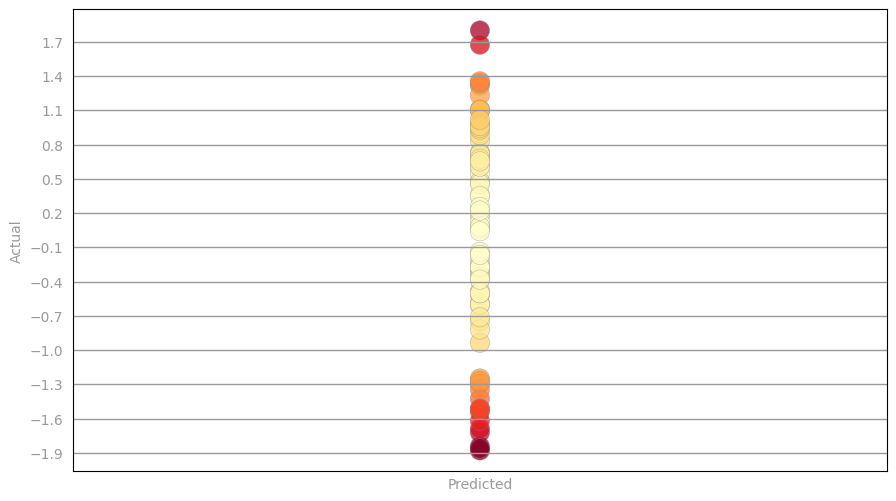

In [13]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm

from matplotlib.colors import ListedColormap, Normalize
from matplotlib.cm import get_cmap
cmap = get_cmap('YlOrRd')
norm = Normalize()

def preparePlot(xticks, yticks, figsize=(10.5, 6), hideLabels=False, gridColor='#999999',
                gridWidth=1.0):
    """Template for generating the plot layout."""
    plt.close()
    fig, ax = plt.subplots(figsize=figsize, facecolor='white', edgecolor='white')
    ax.axes.tick_params(labelcolor='#999999', labelsize='10')
    for axis, ticks in [(ax.get_xaxis(), xticks), (ax.get_yaxis(), yticks)]:
        axis.set_ticks_position('none')
        axis.set_ticks(ticks)
        axis.label.set_color('#999999')
        if hideLabels: axis.set_ticklabels([])
    plt.grid(color=gridColor, linewidth=gridWidth, linestyle='-')
    map(lambda position: ax.spines[position].set_visible(False), ['bottom', 'top', 'left', 'right'])
    return fig, ax


actual = np.asarray(ValData \
                    .map(lambda lp: lp.label) \
                    .collect())

predictions = np.asarray(ValData \
                        .map(lambda lp: 0) \
                        .collect())

error = np.asarray(ValData \
                    .map(lambda lp: (lp.label, 0)) \
                    .map(lambda lp_tuple: squaredError(lp_tuple[0], lp_tuple[1])) \
                    .collect())

clrs = cmap(np.asarray(norm(error)))[:,0:3]

fig, ax = preparePlot(np.arange(-10, 10, 0.3), np.arange(-10, 10, 0.3))
plt.scatter(predictions, actual, s=14**2, c=clrs, edgecolors='#888888', alpha=0.75, linewidths=0.3)
ax.set_xlabel('Predicted'), ax.set_ylabel('Actual')

# Simple Linear Regression

In [43]:
def getLabeledPrediction(weights, observation):
    return (observation.label, weights.dot(observation.features))

In [13]:
def gradientSummand(weights, lp):
    return (weights.dot(lp.features) - lp.label) * lp.features

In [44]:
def linregGradientDescent(trainData, numIters, alpha):
    # The length of the training data
    n = trainData.count()
    # The number of features in the training data
    d = len(trainData.take(1)[0].features)
    w = np.zeros(d)
    # We will compute and store the training error after each iteration
    errorTrain = np.zeros(numIters)
    for i in range(numIters):
        # Use getLabeledPrediction from (3b) with trainData to obtain an RDD of (label, prediction)
        # tuples.  Note that the weights all equal 0 for the first iteration, so the predictions will
        # have large errors to start.
        labelsAndPredsTrain = trainData.map(lambda lp: getLabeledPrediction(w, lp))
        errorTrain[i] = calcRMSE(labelsAndPredsTrain)

        # Calculate the `gradient`.  Make use of the `gradientSummand` function you wrote in (3a).
        # Note that `gradient` sould be a `DenseVector` of length `d`.
        gradient = trainData.map(lambda lp: gradientSummand(w, lp))

        # Update the weights
        alpha_i = alpha / (n * np.sqrt(i+1))
        w -= alpha_i * gradient.sum()
    return w, errorTrain

# create a toy dataset with n = 10, d = 3, and then run 10 iterations of gradient descent
# note: the resulting model will not be useful; the goal here is to verify that
# linregGradientDescent is working properly
exampleN = 10
exampleD = 3
exampleData = (sc \
                .parallelize(TrainData.take(exampleN)) \
                .map(lambda lp: LabeledPoint(lp.label, lp.features[0:exampleD])))
print(exampleData.take(2))

exampleNumIters = 10
exampleWeights, exampleErrorTrain = linregGradientDescent(exampleData, exampleNumIters, 0.001)
print(exampleWeights)
print(exampleErrorTrain)

[LabeledPoint(-1.612425048274252, [2.6547983312509706,0.28421961390978817,-0.5106600651930789]), LabeledPoint(-0.7848866867071304, [2.6547983312509706,0.28421961390978817,-0.5106600651930789])]
[-0.02271393 -0.00243173  0.00436911]
[1.82317342 1.81101734 1.80249053 1.79556809 1.78960103 1.78428554
 1.77945078 1.77498949 1.77082914 1.76691801]


In [16]:
numItersArray = [100, 250, 500]
alphaArray = [1e-1, 5e-1, 1]

for alpha in alphaArray:
    for numIters in numItersArray:
        print(str(alpha)+"\t"+str(numIters))

        weightsLR0, errorTrainLR0 = linregGradientDescent(TrainData, numIters, alpha)

        labelsAndPreds = TrainData.map(lambda x: getLabeledPrediction(weightsLR0, x))
        rmseTrainLR0 = calcRMSE(labelsAndPreds)

        labelsAndPreds = ValData.map(lambda x: getLabeledPrediction(weightsLR0, x))
        rmseValLR0 = calcRMSE(labelsAndPreds)

        print('Train LR0 = {0:.3f}\tValidation LR0 = {1:.3f}'.format(rmseTrainLR0, rmseValLR0))

0.1	100
Train LR0 = 0.113	Validation LR0 = 0.110
0.1	250
Train LR0 = 0.109	Validation LR0 = 0.106
0.1	500


Exception in thread "serve RDD 2322" java.net.SocketTimeoutException: Accept timed out
	at java.base/sun.nio.ch.NioSocketImpl.timedAccept(NioSocketImpl.java:694)
	at java.base/sun.nio.ch.NioSocketImpl.accept(NioSocketImpl.java:738)
	at java.base/java.net.ServerSocket.implAccept(ServerSocket.java:690)
	at java.base/java.net.ServerSocket.platformImplAccept(ServerSocket.java:655)
	at java.base/java.net.ServerSocket.implAccept(ServerSocket.java:631)
	at java.base/java.net.ServerSocket.implAccept(ServerSocket.java:588)
	at java.base/java.net.ServerSocket.accept(ServerSocket.java:546)
	at org.apache.spark.security.SocketAuthServer$$anon$1.run(SocketAuthServer.scala:65)


Train LR0 = 0.107	Validation LR0 = 0.105
0.5	100
Train LR0 = 0.105	Validation LR0 = 0.105
0.5	250
Train LR0 = 0.104	Validation LR0 = 0.105
0.5	500
Train LR0 = 0.104	Validation LR0 = 0.104
1	100
Train LR0 = 0.104	Validation LR0 = 0.104
1	250
Train LR0 = 0.102	Validation LR0 = 0.103
1	500
Train LR0 = 0.101	Validation LR0 = 0.103


In [17]:
weightsLR0, errorTrainLR0 = linregGradientDescent(TrainData, 500, 1)

labelsAndPreds = TrainData.map(lambda x: getLabeledPrediction(weightsLR0, x))
rmseTrainLR0 = calcRMSE(labelsAndPreds)

labelsAndPreds = ValData.map(lambda x: getLabeledPrediction(weightsLR0, x))
rmseValLR0 = calcRMSE(labelsAndPreds)

labelsAndPreds = TestData.map(lambda x: getLabeledPrediction(weightsLR0, x))
rmseTestLR0 = calcRMSE(labelsAndPreds)

print('Train RMSE:\n\tBaseline = {0:.3f}\n\tLR0 = {1:.3f}'.format(rmseTrainBase, rmseTrainLR0))
print('Validation RMSE:\n\tBaseline = {0:.3f}\n\tLR0 = {1:.3f}'.format(rmseValBase, rmseValLR0))
print('Test RMSE:\n\tBaseline = {0:.3f}\n\tLR0 = {1:.3f}'.format(rmseTestBase, rmseTestLR0))

Train RMSE:
	Baseline = 1.000
	LR0 = 0.101
Validation RMSE:
	Baseline = 0.955
	LR0 = 0.103
Test RMSE:
	Baseline = 0.936
	LR0 = 0.102


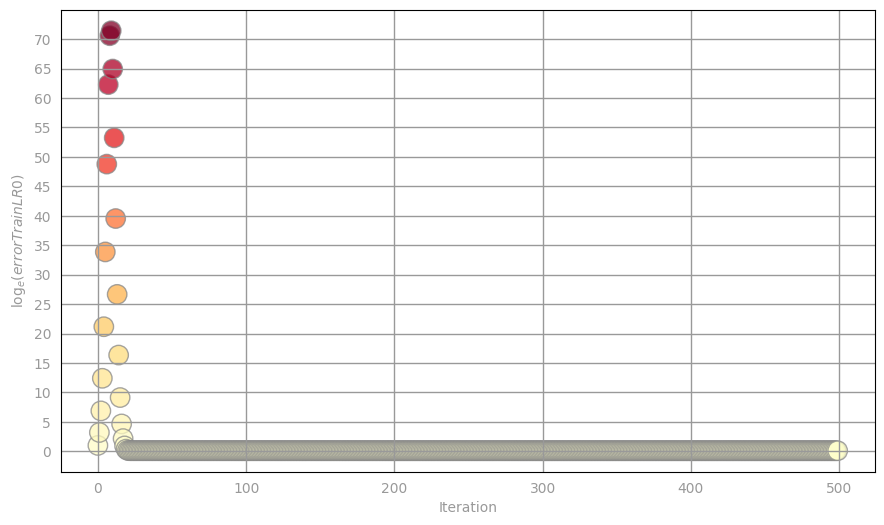

In [30]:
norm = Normalize()
clrs = cmap(np.asarray(norm(errorTrainLR0)))[:,0:3]

fig, ax = preparePlot(np.arange(0, 1000, 100), np.arange(0, 100, 5))
plt.scatter(range(0, numIters), errorTrainLR0, s=14**2, c=clrs, edgecolors='#888888', alpha=0.75)
ax.set_xlabel('Iteration'), ax.set_ylabel(r'$\log_e(errorTrainLR0)$')
pass

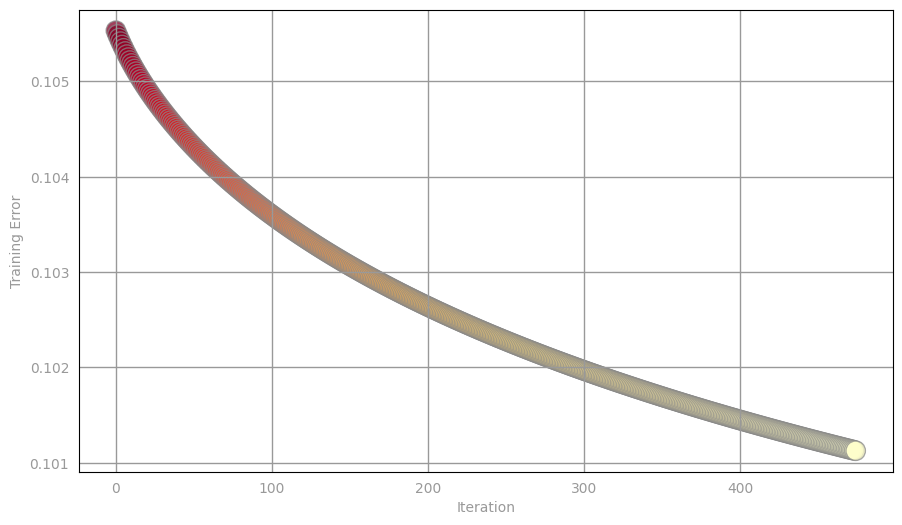

In [35]:
norm = Normalize()
clrs = cmap(np.asarray(norm(errorTrainLR0[25:])))[:,0:3]

fig, ax = preparePlot(np.arange(0, 1000, 100), np.arange(0, 1, 0.001))
plt.scatter(range(0, numIters-25), errorTrainLR0[25:], s=14**2, c=clrs, edgecolors='#888888', alpha=0.75)
ax.set_xlabel('Iteration'), ax.set_ylabel(r'Training Error')
pass

## Train

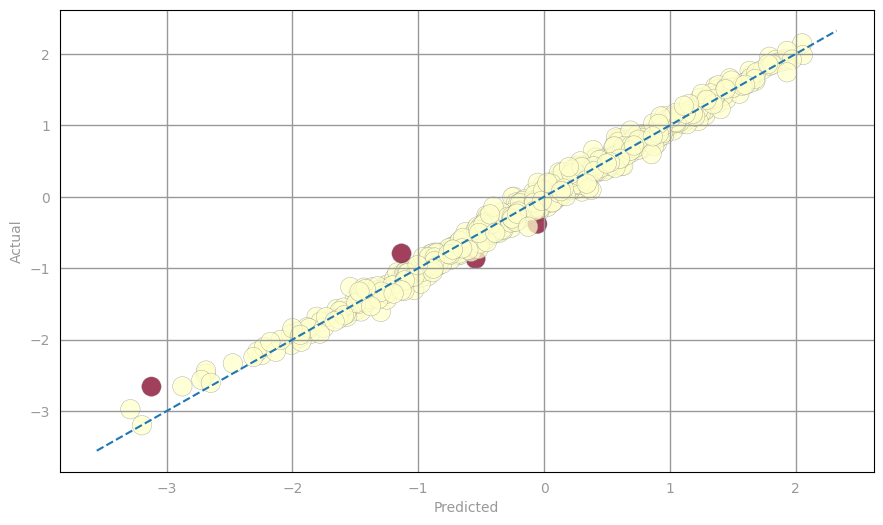

In [38]:
actual = np.asarray(TrainData \
                    .map(lambda lp: lp.label) \
                    .collect())

predictions = np.asarray(TrainData \
                        .map(lambda x: getLabeledPrediction(weightsLR0, x)) \
                        .map(lambda lp: lp[1]) \
                        .collect())

error = np.asarray(TrainData \
                    .map(lambda x: getLabeledPrediction(weightsLR0, x)) \
                    .map(lambda lp_tuple: squaredError(lp_tuple[0], lp_tuple[1])) \
                    .collect())

clrs = cmap(np.asarray(norm(error)))[:,0:3]

fig, ax = preparePlot(np.arange(-10, 10, 1), np.arange(-10, 10, 1))
plt.scatter(predictions, actual, s=14**2, c=clrs, edgecolors='#888888', alpha=0.75, linewidths=0.3)
ax.set_xlabel('Predicted'), ax.set_ylabel('Actual')

x_vals = np.array(ax.get_xlim())
y_vals = 1 * x_vals
plt.plot(x_vals, y_vals, '--')

## Val

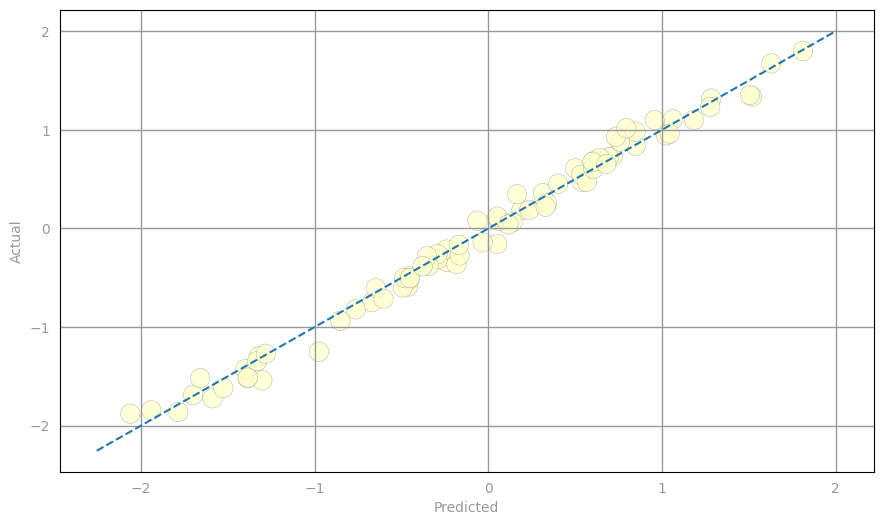

In [39]:
actual = np.asarray(ValData \
                    .map(lambda lp: lp.label) \
                    .collect())

predictions = np.asarray(ValData \
                        .map(lambda x: getLabeledPrediction(weightsLR0, x)) \
                        .map(lambda lp: lp[1]) \
                        .collect())

error = np.asarray(ValData \
                    .map(lambda x: getLabeledPrediction(weightsLR0, x)) \
                    .map(lambda lp_tuple: squaredError(lp_tuple[0], lp_tuple[1])) \
                    .collect())

clrs = cmap(np.asarray(norm(error)))[:,0:3]

fig, ax = preparePlot(np.arange(-10, 10, 1), np.arange(-10, 10, 1))
plt.scatter(predictions, actual, s=14**2, c=clrs, edgecolors='#888888', alpha=0.75, linewidths=0.3)
ax.set_xlabel('Predicted'), ax.set_ylabel('Actual')

x_vals = np.array(ax.get_xlim())
y_vals = 1 * x_vals
plt.plot(x_vals, y_vals, '--')

## Test

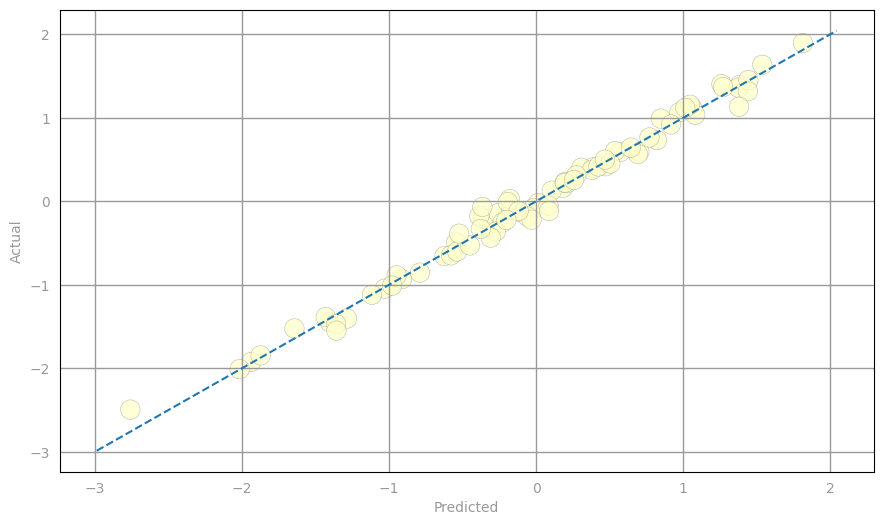

In [40]:
actual = np.asarray(TestData \
                    .map(lambda lp: lp.label) \
                    .collect())

predictions = np.asarray(TestData \
                        .map(lambda x: getLabeledPrediction(weightsLR0, x)) \
                        .map(lambda lp: lp[1]) \
                        .collect())

error = np.asarray(TestData \
                    .map(lambda x: getLabeledPrediction(weightsLR0, x)) \
                    .map(lambda lp_tuple: squaredError(lp_tuple[0], lp_tuple[1])) \
                    .collect())

clrs = cmap(np.asarray(norm(error)))[:,0:3]

fig, ax = preparePlot(np.arange(-10, 10, 1), np.arange(-10, 10, 1))
plt.scatter(predictions, actual, s=14**2, c=clrs, edgecolors='#888888', alpha=0.75, linewidths=0.3)
ax.set_xlabel('Predicted'), ax.set_ylabel('Actual')

x_vals = np.array(ax.get_xlim())
y_vals = 1 * x_vals
plt.plot(x_vals, y_vals, '--')

# Multi Layer Perceptron

In [14]:
def squaredError(label, prediction):
    return (float(label)-float(prediction))**2

def calcRMSE(labelsAndPreds):
    se = labelsAndPreds.map(lambda x: squaredError(x[0], x[1])).collect()
    return np.sqrt(np.mean(se))

In [15]:
def MLPGradientDescent(trainData, numIters, alpha):
    # The length of the training data
    n = trainData.count()
    # The number of features in the training data
    d = len(trainData.take(1)[0].features)
    w1 = 1e-1 * np.random.randn(8, d)
    w2 = 1e-1 * np.random.randn(4, 8)
    w3 = 1e-1 * np.random.randn(1, 4)
    # We will compute and store the training error after each iteration
    errorTrain = np.zeros(numIters)
    for i in range(numIters):
        # z2 = x1 * w1
        z2 = trainData.map(lambda lp: (lp.label, w1.dot(lp.features)))
        # x2 = ReLU(z2)
        x2 = z2.map(lambda lp: (lp[0], np.maximum(lp[1], 0)))
        # z3 = x2 * w2
        z3 = x2.map(lambda lp: (lp[0], w2.dot(lp[1])))
        # x3 = ReLU(z3)
        x3 = z3.map(lambda lp: (lp[0], np.maximum(lp[1], 0)))
        # outcome = x3 * w3
        labelsAndPredsTrain = x3.map(lambda lp: (lp[0], w3.dot(lp[1])))
        errorTrain[i] = calcRMSE(labelsAndPredsTrain)

        # Calculate the `gradient`. 
        # 1 * 4
        gW3 = x3.map(lambda lp: (w3.dot(lp[1]) - lp[0]) * lp[1]).sum()

        # n * 4
        gX3 = np.matrix(x3.map(lambda lp: (w3.dot(lp[1]) - lp[0]).dot(w3)).collect())
        gZ3 = np.multiply((np.matrix(z3.map(lambda lp: lp[1]).collect()) > 0), gX3)
        # 4 * 8
        gW2 = gZ3.T.dot(np.matrix(z2.map(lambda lp: lp[1]).collect()))
        
        # n * 8
        gX2 = gZ3.dot(w2)
        gZ2 = np.multiply((np.matrix(z2.map(lambda lp: lp[1]).collect()) > 0), gX2)
        # 8 * d
        gW1 = gZ2.T.dot(np.matrix(trainData.map(lambda lp: lp.features).collect()))
        
        # Update the weights
        alpha_i = alpha / (n * np.sqrt(i+1))
        w3 -= alpha_i * gW3
        w2 -= alpha_i * gW2
        w1 -= alpha_i * gW1

    return w1, w2, w3, errorTrain

In [198]:
# create a toy dataset with n = 10, d = 3, and then run 10 iterations of gradient descent
# note: the resulting model will not be useful; the goal here is to verify that
# linregGradientDescent is working properly
exampleN = 10
exampleD = 3
exampleData = (sc \
                .parallelize(TrainData.take(exampleN)) \
                .map(lambda lp: LabeledPoint(lp.label, lp.features[0:exampleD])))
print(exampleData.take(2))

exampleNumIters = 10
exampleW1, exampleW2, exampleW3, exampleErrorTrain = MLPGradientDescent(exampleData, exampleNumIters, 0.0001)
print(exampleW3)
print(exampleErrorTrain)

[LabeledPoint(-1.612425048274252, [2.6547983312509706,0.28421961390978817,-0.5106600651930789]), LabeledPoint(-0.7848866867071304, [2.6547983312509706,0.28421961390978817,-0.5106600651930789])]
[[-0.25915125  1.25819126  0.74227275  0.21156007]]
[1.1305069  1.12927948 1.12841163 1.12770306 1.12708944 1.1265406
 1.1260396  1.12557577 1.1251419  1.12473284]


In [261]:
numItersArray = [100, 250, 500]
alphaArray = [7e-3, 1e-2, 3e-2]

for alpha in alphaArray:
    for numIters in numItersArray:
        print(str(alpha)+"\t"+str(numIters))

        w1, w2, w3, errorTrainMLP0 = MLPGradientDescent(TrainData, numIters, alpha)

        labelsAndPreds = TrainData.map(lambda lp: (lp.label, w1.dot(lp.features))) \
                                .map(lambda lp: (lp[0], np.maximum(lp[1], 0))) \
                                .map(lambda lp: (lp[0], w2.dot(lp[1]))) \
                                .map(lambda lp: (lp[0], np.maximum(lp[1], 0))) \
                                .map(lambda lp: (lp[0], w3.dot(lp[1])))
        rmseTrainMLP0 = calcRMSE(labelsAndPreds)

        labelsAndPreds = ValData.map(lambda lp: (lp.label, w1.dot(lp.features))) \
                                .map(lambda lp: (lp[0], np.maximum(lp[1], 0))) \
                                .map(lambda lp: (lp[0], w2.dot(lp[1]))) \
                                .map(lambda lp: (lp[0], np.maximum(lp[1], 0))) \
                                .map(lambda lp: (lp[0], w3.dot(lp[1])))
        rmseValMLP0 = calcRMSE(labelsAndPreds)

        print('Train MLP0 = {0:.3f}\tValidation MLP0 = {1:.3f}'.format(rmseTrainMLP0, rmseValMLP0))

0.007	100
Train MLP0 = 1.194	Validation MLP0 = 1.060
0.007	250
Train MLP0 = 1.593	Validation MLP0 = 1.514
0.007	500
Train MLP0 = 0.937	Validation MLP0 = 0.985
0.01	100
Train MLP0 = 1.193	Validation MLP0 = 1.516
0.01	250
Train MLP0 = 1.122	Validation MLP0 = 1.317
0.01	500
Train MLP0 = 1.190	Validation MLP0 = 1.216
0.03	100
Train MLP0 = 0.804	Validation MLP0 = 0.791
0.03	250
Train MLP0 = 0.765	Validation MLP0 = 0.792
0.03	500
Train MLP0 = 0.685	Validation MLP0 = 0.778


In [17]:
numIters = 500
w1, w2, w3, errorTrainMLP0 = MLPGradientDescent(TrainData, numIters, 5e-1)

labelsAndPreds = TrainData.map(lambda lp: (lp.label, w1.dot(lp.features))) \
                                .map(lambda lp: (lp[0], np.maximum(lp[1], 0))) \
                                .map(lambda lp: (lp[0], w2.dot(lp[1]))) \
                                .map(lambda lp: (lp[0], np.maximum(lp[1], 0))) \
                                .map(lambda lp: (lp[0], w3.dot(lp[1])))
rmseTrainMLP0 = calcRMSE(labelsAndPreds)

labelsAndPreds = ValData.map(lambda lp: (lp.label, w1.dot(lp.features))) \
                                .map(lambda lp: (lp[0], np.maximum(lp[1], 0))) \
                                .map(lambda lp: (lp[0], w2.dot(lp[1]))) \
                                .map(lambda lp: (lp[0], np.maximum(lp[1], 0))) \
                                .map(lambda lp: (lp[0], w3.dot(lp[1])))
rmseValMLP0 = calcRMSE(labelsAndPreds)

labelsAndPreds = TestData.map(lambda lp: (lp.label, w1.dot(lp.features))) \
                                .map(lambda lp: (lp[0], np.maximum(lp[1], 0))) \
                                .map(lambda lp: (lp[0], w2.dot(lp[1]))) \
                                .map(lambda lp: (lp[0], np.maximum(lp[1], 0))) \
                                .map(lambda lp: (lp[0], w3.dot(lp[1])))
rmseTestMLP0 = calcRMSE(labelsAndPreds)

print('Train RMSE:\n\tBaseline = {0:.3f}\n\tMLP0 = {1:.3f}'.format(rmseTrainBase, rmseTrainMLP0))
print('Validation RMSE:\n\tBaseline = {0:.3f}\n\tMLP0 = {1:.3f}'.format(rmseValBase, rmseValMLP0))
print('Test RMSE:\n\tBaseline = {0:.3f}\n\tMLP0 = {1:.3f}'.format(rmseTestBase, rmseTestMLP0))

Train RMSE:
	Baseline = 1.000
	MLP0 = 0.108
Validation RMSE:
	Baseline = 0.955
	MLP0 = 0.106
Test RMSE:
	Baseline = 0.936
	MLP0 = 0.098


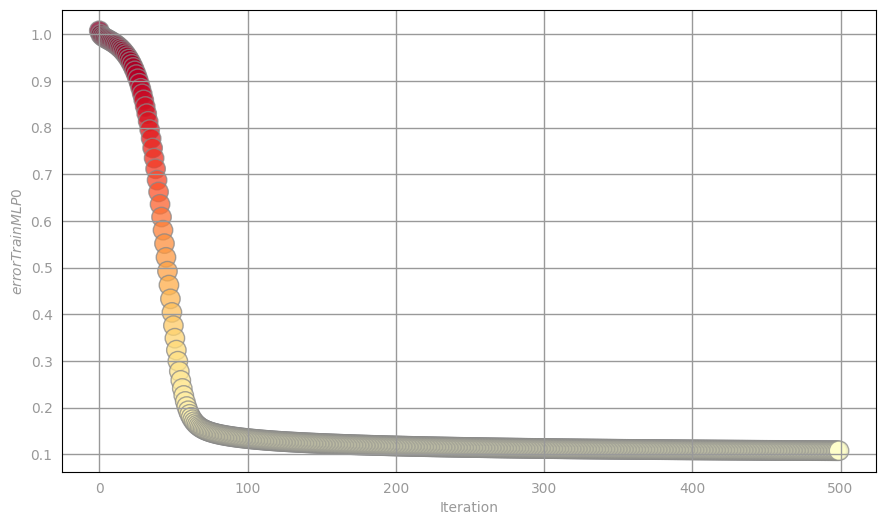

In [18]:
norm = Normalize()
clrs = cmap(np.asarray(norm(errorTrainMLP0)))[:,0:3]

fig, ax = preparePlot(np.arange(0, 1000, 100), np.arange(0, 100, 0.1))
plt.scatter(range(0, numIters), errorTrainMLP0, s=14**2, c=clrs, edgecolors='#888888', alpha=0.75)
ax.set_xlabel('Iteration'), ax.set_ylabel(r'$errorTrainMLP0$')
pass

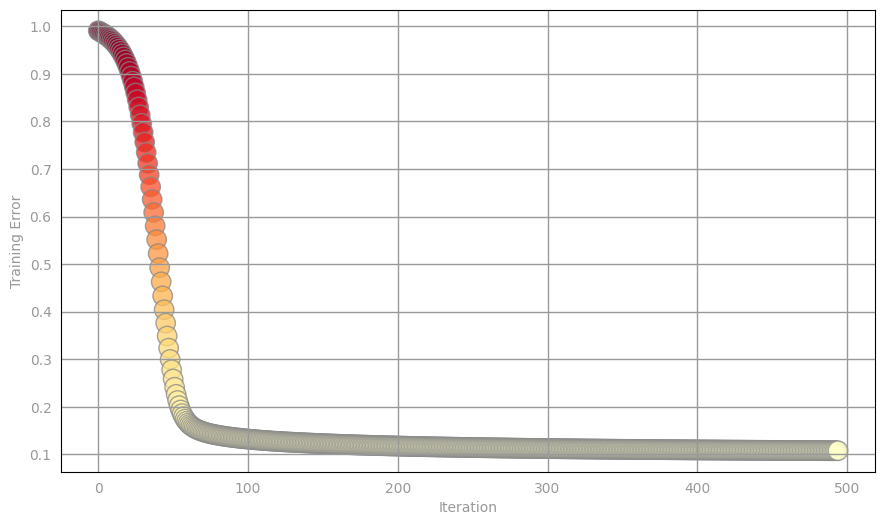

In [19]:
norm = Normalize()
clrs = cmap(np.asarray(norm(errorTrainMLP0[5:])))[:,0:3]

fig, ax = preparePlot(np.arange(0, 1000, 100), np.arange(0, 10, 0.1))
plt.scatter(range(0, numIters-5), errorTrainMLP0[5:], s=14**2, c=clrs, edgecolors='#888888', alpha=0.75)
ax.set_xlabel('Iteration'), ax.set_ylabel(r'Training Error')
pass

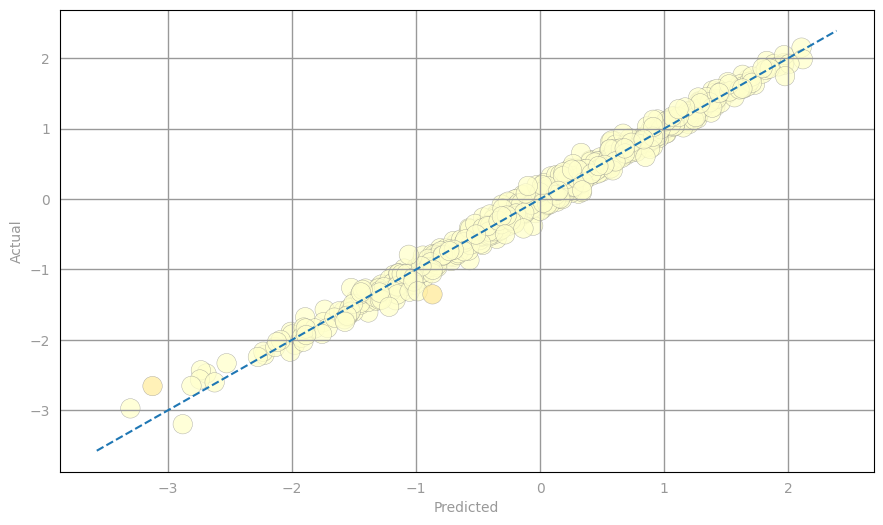

In [20]:
actual = np.asarray(TrainData \
                    .map(lambda lp: lp.label) \
                    .collect())

predictions = np.asarray(TrainData \
                        .map(lambda lp: (w1.dot(lp.features))) \
                        .map(lambda lp: (np.maximum(lp, 0))) \
                        .map(lambda lp: (w2.dot(lp))) \
                        .map(lambda lp: (np.maximum(lp, 0))) \
                        .map(lambda lp: (w3.dot(lp))) \
                        .collect())

error = np.asarray(TrainData \
                    .map(lambda lp: (lp.label, w1.dot(lp.features))) \
                    .map(lambda lp: (lp[0], np.maximum(lp[1], 0))) \
                    .map(lambda lp: (lp[0], w2.dot(lp[1]))) \
                    .map(lambda lp: (lp[0], np.maximum(lp[1], 0))) \
                    .map(lambda lp: (lp[0], w3.dot(lp[1]))) \
                    .map(lambda lp_tuple: squaredError(lp_tuple[0], lp_tuple[1])) \
                    .collect())

clrs = cmap(np.asarray(norm(error)))[:,0:3]

fig, ax = preparePlot(np.arange(-10, 10, 1), np.arange(-10, 10, 1))
plt.scatter(predictions, actual, s=14**2, c=clrs, edgecolors='#888888', alpha=0.75, linewidths=0.3)
ax.set_xlabel('Predicted'), ax.set_ylabel('Actual')

x_vals = np.array(ax.get_xlim())
y_vals = 1 * x_vals
plt.plot(x_vals, y_vals, '--')

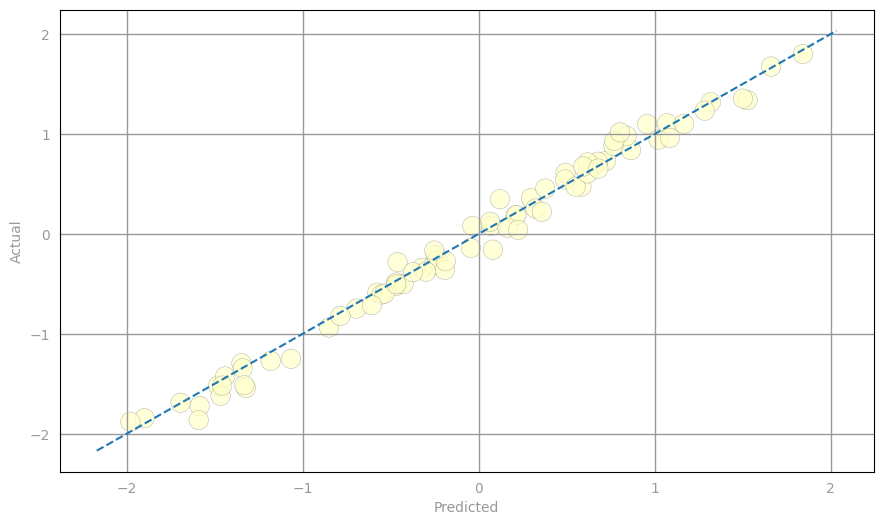

In [21]:
actual = np.asarray(ValData \
                    .map(lambda lp: lp.label) \
                    .collect())

predictions = np.asarray(ValData \
                        .map(lambda lp: (w1.dot(lp.features))) \
                        .map(lambda lp: (np.maximum(lp, 0))) \
                        .map(lambda lp: (w2.dot(lp))) \
                        .map(lambda lp: (np.maximum(lp, 0))) \
                        .map(lambda lp: (w3.dot(lp))) \
                        .collect())

error = np.asarray(ValData \
                    .map(lambda lp: (lp.label, w1.dot(lp.features))) \
                    .map(lambda lp: (lp[0], np.maximum(lp[1], 0))) \
                    .map(lambda lp: (lp[0], w2.dot(lp[1]))) \
                    .map(lambda lp: (lp[0], np.maximum(lp[1], 0))) \
                    .map(lambda lp: (lp[0], w3.dot(lp[1]))) \
                    .map(lambda lp_tuple: squaredError(lp_tuple[0], lp_tuple[1])) \
                    .collect())

clrs = cmap(np.asarray(norm(error)))[:,0:3]

fig, ax = preparePlot(np.arange(-10, 10, 1), np.arange(-10, 10, 1))
plt.scatter(predictions, actual, s=14**2, c=clrs, edgecolors='#888888', alpha=0.75, linewidths=0.3)
ax.set_xlabel('Predicted'), ax.set_ylabel('Actual')

x_vals = np.array(ax.get_xlim())
y_vals = 1 * x_vals
plt.plot(x_vals, y_vals, '--')

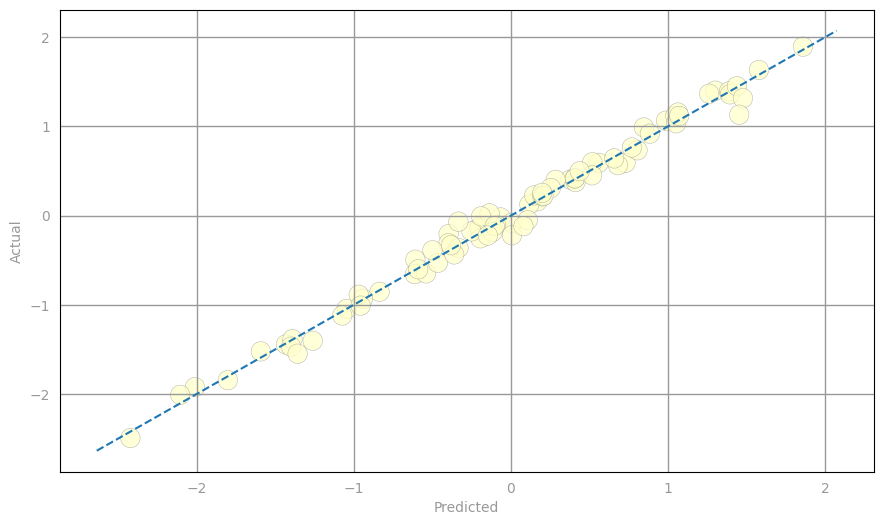

In [22]:
actual = np.asarray(TestData \
                    .map(lambda lp: lp.label) \
                    .collect())

predictions = np.asarray(TestData \
                        .map(lambda lp: (w1.dot(lp.features))) \
                        .map(lambda lp: (np.maximum(lp, 0))) \
                        .map(lambda lp: (w2.dot(lp))) \
                        .map(lambda lp: (np.maximum(lp, 0))) \
                        .map(lambda lp: (w3.dot(lp))) \
                        .collect())

error = np.asarray(TestData \
                    .map(lambda lp: (lp.label, w1.dot(lp.features))) \
                    .map(lambda lp: (lp[0], np.maximum(lp[1], 0))) \
                    .map(lambda lp: (lp[0], w2.dot(lp[1]))) \
                    .map(lambda lp: (lp[0], np.maximum(lp[1], 0))) \
                    .map(lambda lp: (lp[0], w3.dot(lp[1]))) \
                    .map(lambda lp_tuple: squaredError(lp_tuple[0], lp_tuple[1])) \
                    .collect())

clrs = cmap(np.asarray(norm(error)))[:,0:3]

fig, ax = preparePlot(np.arange(-10, 10, 1), np.arange(-10, 10, 1))
plt.scatter(predictions, actual, s=14**2, c=clrs, edgecolors='#888888', alpha=0.75, linewidths=0.3)
ax.set_xlabel('Predicted'), ax.set_ylabel('Actual')

x_vals = np.array(ax.get_xlim())
y_vals = 1 * x_vals
plt.plot(x_vals, y_vals, '--')

# Train.csv

In [8]:
data = sc.textFile('./data/train.csv')
header = data.first() #extract header
data = data.filter(lambda row: row != header)

In [10]:
print(data.take(1)[0])

print(len(data.take(1)[0].split(",")))

print(data.take(1)[0].split(",")[18-1])
print(data.take(1)[0].split(",")[1:18-1])

0,25.0,0.5,0.25,0.75,0.5,69.7,42.1,58.2,50.2,24.3,41.2,24.0,0.39,0.425010896,0.417545412,32.46088718,4476.81146
18
4476.81146
['25.0', '0.5', '0.25', '0.75', '0.5', '69.7', '42.1', '58.2', '50.2', '24.3', '41.2', '24.0', '0.39', '0.425010896', '0.417545412', '32.46088718']


In [11]:
def parsePoint(line):
    string = line.split(",")
    return LabeledPoint(string[len(string)-1], string[1:len(string)-1])

parsedData = data.map(parsePoint)

In [25]:
weights = [.8, .2]
seed = 42
preTrainData, preValData = parsedData.randomSplit(weights, seed)
nTrain = preTrainData.count()
nVal = preValData.count()

print(nTrain, nVal, nTrain + nVal)
print(data.count())

12236 3053 15289
15289


In [26]:
print(preTrainData.collect()[0])
len(preTrainData.collect()[0].features)

(4476.81146,[25.0,0.5,0.25,0.75,0.5,69.7,42.1,58.2,50.2,24.3,41.2,24.0,0.39,0.425010896,0.417545412,32.46088718])


16

In [27]:
def squaredError(label, prediction):
    return (float(label)-float(prediction))**2

def calcRMSE(labelsAndPreds):
    se = labelsAndPreds.map(lambda x: squaredError(x[0], x[1])).collect()
    return np.sqrt(np.mean(se))

In [28]:
averageLabel = preTrainData.map(lambda x: x.label).mean()
averageLabelsd = preTrainData.map(lambda x: x.label).stdev()
print(averageLabel)
print(averageLabelsd)

averageFeatmu = [0 for i in range(16)]
averageFeatsd = [0 for i in range(16)]
for i in range(16):
    averageFeatmu[i] = preTrainData.map(lambda x: x.features[i]).mean()
    averageFeatsd[i] = preTrainData.map(lambda x: x.features[i]).stdev()

print(averageFeatmu)
print(averageFeatsd)

6023.398903789623
1339.7447824773453


Exception in thread "serve RDD 330" java.net.SocketTimeoutException: Accept timed out
	at java.base/sun.nio.ch.NioSocketImpl.timedAccept(NioSocketImpl.java:694)
	at java.base/sun.nio.ch.NioSocketImpl.accept(NioSocketImpl.java:738)
	at java.base/java.net.ServerSocket.implAccept(ServerSocket.java:690)
	at java.base/java.net.ServerSocket.platformImplAccept(ServerSocket.java:655)
	at java.base/java.net.ServerSocket.implAccept(ServerSocket.java:631)
	at java.base/java.net.ServerSocket.implAccept(ServerSocket.java:588)
	at java.base/java.net.ServerSocket.accept(ServerSocket.java:546)
	at org.apache.spark.security.SocketAuthServer$$anon$1.run(SocketAuthServer.scala:65)


[19.695161817587554, 0.3890250081726055, 0.2868274762994429, 0.49333303367113435, 0.5919854527623428, 82.17775416802901, 49.67714939522713, 68.66153154625728, 59.23401438378567, 28.66283099051975, 48.57248283752851, 18.609968126838872, 0.32347826086956644, 0.5029321247036299, 0.4466245484818157, 36.18111076215747]
[6.585746280285208, 0.35984700791205737, 0.05999193364274759, 0.14801427152145405, 0.13943557925634473, 9.160601429967542, 5.554826960745077, 7.652706378459115, 6.620185453902025, 3.200033910188398, 5.398424462407116, 11.667181927081279, 0.16395367601799338, 0.07440500849561647, 0.03709224561432775, 4.035841318613487]


In [29]:
TrainData = preTrainData.map(lambda x: LabeledPoint((x.label-averageLabel)/averageLabelsd,
                                        [(x.features[i]-averageFeatmu[i])/averageFeatsd[i] for i in range(16)]))
ValData = preValData.map(lambda x: LabeledPoint((x.label-averageLabel)/averageLabelsd,
                                        [(x.features[i]-averageFeatmu[i])/averageFeatsd[i] for i in range(16)]))

TrainData.cache()
ValData.cache()

labelsAndPredsTrain = TrainData.map(lambda x: (x.label, 0))
rmseTrainBase = calcRMSE(labelsAndPredsTrain)

labelsAndPredsVal = ValData.map(lambda x: (x.label, 0))
rmseValBase = calcRMSE(labelsAndPredsVal)

print('Baseline Train RMSE = {0:.3f}'.format(rmseTrainBase))
print('Baseline Validation RMSE = {0:.3f}'.format(rmseValBase))

Baseline Train RMSE = 1.000
Baseline Validation RMSE = 0.990


In [30]:
TrainData.collect()[0]

LabeledPoint(-1.1543896001817608, [0.8055029690853366,0.30839492725340534,-0.6138738004137486,1.7340690440898656,-0.659698573727962,-1.3621108028136555,-1.364065784366179,-1.3670368401568966,-1.3646165121342484,-1.3633702369931744,-1.3656730568090927,0.4619823284532879,0.4057349657907825,-1.0472578429746509,-0.7839680774297257,-0.9217962968463674])

(Text(0.5, 0, 'Predicted'), Text(0, 0.5, 'Actual'))

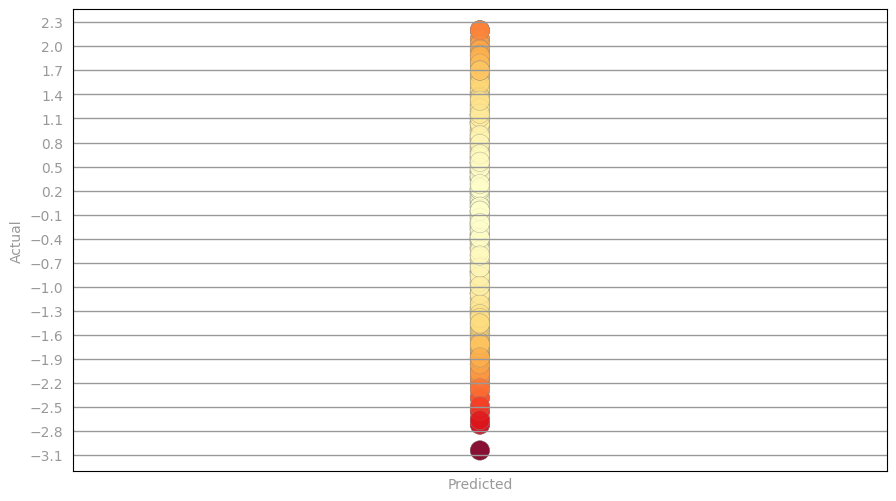

In [31]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm

from matplotlib.colors import ListedColormap, Normalize
from matplotlib.cm import get_cmap
cmap = get_cmap('YlOrRd')
norm = Normalize()

def preparePlot(xticks, yticks, figsize=(10.5, 6), hideLabels=False, gridColor='#999999',
                gridWidth=1.0):
    """Template for generating the plot layout."""
    plt.close()
    fig, ax = plt.subplots(figsize=figsize, facecolor='white', edgecolor='white')
    ax.axes.tick_params(labelcolor='#999999', labelsize='10')
    for axis, ticks in [(ax.get_xaxis(), xticks), (ax.get_yaxis(), yticks)]:
        axis.set_ticks_position('none')
        axis.set_ticks(ticks)
        axis.label.set_color('#999999')
        if hideLabels: axis.set_ticklabels([])
    plt.grid(color=gridColor, linewidth=gridWidth, linestyle='-')
    map(lambda position: ax.spines[position].set_visible(False), ['bottom', 'top', 'left', 'right'])
    return fig, ax


actual = np.asarray(ValData \
                    .map(lambda lp: lp.label) \
                    .collect())

predictions = np.asarray(ValData \
                        .map(lambda lp: 0) \
                        .collect())

error = np.asarray(ValData \
                    .map(lambda lp: (lp.label, 0)) \
                    .map(lambda lp_tuple: squaredError(lp_tuple[0], lp_tuple[1])) \
                    .collect())

clrs = cmap(np.asarray(norm(error)))[:,0:3]

fig, ax = preparePlot(np.arange(-10, 10, 0.3), np.arange(-10, 10, 0.3))
plt.scatter(predictions, actual, s=14**2, c=clrs, edgecolors='#888888', alpha=0.75, linewidths=0.3)
ax.set_xlabel('Predicted'), ax.set_ylabel('Actual')

# Simple Linear Regression

In [32]:
def getLabeledPrediction(weights, observation):
    return (observation.label, weights.dot(observation.features))

In [33]:

def gradientSummand(weights, lp):
    return (weights.dot(lp.features) - lp.label) * lp.features

In [34]:
def linregGradientDescent(trainData, numIters, alpha):
    # The length of the training data
    n = trainData.count()
    # The number of features in the training data
    d = len(trainData.take(1)[0].features)
    w = np.zeros(d)
    # We will compute and store the training error after each iteration
    errorTrain = np.zeros(numIters)
    for i in range(numIters):
        # Use getLabeledPrediction from (3b) with trainData to obtain an RDD of (label, prediction)
        # tuples.  Note that the weights all equal 0 for the first iteration, so the predictions will
        # have large errors to start.
        labelsAndPredsTrain = trainData.map(lambda lp: getLabeledPrediction(w, lp))
        errorTrain[i] = calcRMSE(labelsAndPredsTrain)

        # Calculate the `gradient`.  Make use of the `gradientSummand` function you wrote in (3a).
        # Note that `gradient` sould be a `DenseVector` of length `d`.
        gradient = trainData.map(lambda lp: gradientSummand(w, lp))

        # Update the weights
        alpha_i = alpha / (n * np.sqrt(i+1))
        w -= alpha_i * gradient.sum()
    return w, errorTrain

# create a toy dataset with n = 10, d = 3, and then run 10 iterations of gradient descent
# note: the resulting model will not be useful; the goal here is to verify that
# linregGradientDescent is working properly
exampleN = 10
exampleD = 3
exampleData = (sc \
                .parallelize(TrainData.take(exampleN)) \
                .map(lambda lp: LabeledPoint(lp.label, lp.features[0:exampleD])))
print(exampleData.take(2))

exampleNumIters = 10
exampleWeights, exampleErrorTrain = linregGradientDescent(exampleData, exampleNumIters, 0.1)
print(exampleWeights)
print(exampleErrorTrain)

23/05/15 17:37:06 WARN BlockManager: Task 367 already completed, not releasing lock for rdd_369_0


[LabeledPoint(-1.1543896001817608, [0.8055029690853366,0.30839492725340534,-0.6138738004137486]), LabeledPoint(-0.35475181542471085, [0.8055029690853366,0.30839492725340534,-0.6138738004137486])]
[-0.16535103 -0.05702356  0.04318331]
[1.0163273  0.99648165 0.98513006 0.97716763 0.97108162 0.96619843
 0.96215445 0.9587295  0.95577959 0.95320515]


In [35]:
numItersArray = [100, 250, 500]
alphaArray = [1e-1, 5e-1, 1]

for alpha in alphaArray:
    for numIters in numItersArray:
        print(str(alpha)+"\t"+str(numIters))

        weightsLR0, errorTrainLR0 = linregGradientDescent(TrainData, numIters, alpha)

        labelsAndPreds = TrainData.map(lambda x: getLabeledPrediction(weightsLR0, x))
        rmseTrainLR0 = calcRMSE(labelsAndPreds)

        labelsAndPreds = ValData.map(lambda x: getLabeledPrediction(weightsLR0, x))
        rmseValLR0 = calcRMSE(labelsAndPreds)

        print('Train LR0 = {0:.3f}\tValidation LR0 = {1:.3f}'.format(rmseTrainLR0, rmseValLR0))

0.1	100


23/05/15 17:37:14 WARN BlockManager: Task 392 already completed, not releasing lock for rdd_369_0


Train LR0 = 0.457	Validation LR0 = 0.455
0.1	250


23/05/15 17:37:44 WARN BlockManager: Task 596 already completed, not releasing lock for rdd_369_0


Train LR0 = 0.453	Validation LR0 = 0.453
0.1	500


23/05/15 17:38:56 WARN BlockManager: Task 1100 already completed, not releasing lock for rdd_369_0
ERROR:root:KeyboardInterrupt while sending command.                             
Traceback (most recent call last):
  File "/Users/LuMiNaE/Library/Python/3.7/lib/python/site-packages/py4j/java_gateway.py", line 1038, in send_command
    response = connection.send_command(command)
  File "/Users/LuMiNaE/Library/Python/3.7/lib/python/site-packages/py4j/clientserver.py", line 511, in send_command
    answer = smart_decode(self.stream.readline()[:-1])
  File "/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/socket.py", line 589, in readinto
    return self._sock.recv_into(b)
KeyboardInterrupt


KeyboardInterrupt: 

In [ ]:
weightsLR0, errorTrainLR0 = linregGradientDescent(TrainData, 500, 1)

labelsAndPreds = TrainData.map(lambda x: getLabeledPrediction(weightsLR0, x))
rmseTrainLR0 = calcRMSE(labelsAndPreds)

labelsAndPreds = ValData.map(lambda x: getLabeledPrediction(weightsLR0, x))
rmseValLR0 = calcRMSE(labelsAndPreds)

labelsAndPreds = TestData.map(lambda x: getLabeledPrediction(weightsLR0, x))
rmseTestLR0 = calcRMSE(labelsAndPreds)

print('Train RMSE:\n\tBaseline = {0:.3f}\n\tLR0 = {1:.3f}'.format(rmseTrainBase, rmseTrainLR0))
print('Validation RMSE:\n\tBaseline = {0:.3f}\n\tLR0 = {1:.3f}'.format(rmseValBase, rmseValLR0))
print('Test RMSE:\n\tBaseline = {0:.3f}\n\tLR0 = {1:.3f}'.format(rmseTestBase, rmseTestLR0))

In [ ]:
norm = Normalize()
clrs = cmap(np.asarray(norm(errorTrainLR0)))[:,0:3]

fig, ax = preparePlot(np.arange(0, 1000, 100), np.arange(0, 100, 5))
plt.scatter(range(0, numIters), errorTrainLR0, s=14**2, c=clrs, edgecolors='#888888', alpha=0.75)
ax.set_xlabel('Iteration'), ax.set_ylabel(r'$\log_e(errorTrainLR0)$')
pass

In [ ]:
norm = Normalize()
clrs = cmap(np.asarray(norm(errorTrainLR0[25:])))[:,0:3]

fig, ax = preparePlot(np.arange(0, 1000, 100), np.arange(0, 1, 0.001))
plt.scatter(range(0, numIters-25), errorTrainLR0[25:], s=14**2, c=clrs, edgecolors='#888888', alpha=0.75)
ax.set_xlabel('Iteration'), ax.set_ylabel(r'Training Error')
pass

In [ ]:
actual = np.asarray(TrainData \
                    .map(lambda lp: lp.label) \
                    .collect())

predictions = np.asarray(TrainData \
                        .map(lambda x: getLabeledPrediction(weightsLR0, x)) \
                        .map(lambda lp: lp[1]) \
                        .collect())

error = np.asarray(TrainData \
                    .map(lambda x: getLabeledPrediction(weightsLR0, x)) \
                    .map(lambda lp_tuple: squaredError(lp_tuple[0], lp_tuple[1])) \
                    .collect())

clrs = cmap(np.asarray(norm(error)))[:,0:3]

fig, ax = preparePlot(np.arange(-10, 10, 1), np.arange(-10, 10, 1))
plt.scatter(predictions, actual, s=14**2, c=clrs, edgecolors='#888888', alpha=0.75, linewidths=0.3)
ax.set_xlabel('Predicted'), ax.set_ylabel('Actual')

x_vals = np.array(ax.get_xlim())
y_vals = 1 * x_vals
plt.plot(x_vals, y_vals, '--')

In [ ]:
actual = np.asarray(ValData \
                    .map(lambda lp: lp.label) \
                    .collect())

predictions = np.asarray(ValData \
                        .map(lambda x: getLabeledPrediction(weightsLR0, x)) \
                        .map(lambda lp: lp[1]) \
                        .collect())

error = np.asarray(ValData \
                    .map(lambda x: getLabeledPrediction(weightsLR0, x)) \
                    .map(lambda lp_tuple: squaredError(lp_tuple[0], lp_tuple[1])) \
                    .collect())

clrs = cmap(np.asarray(norm(error)))[:,0:3]

fig, ax = preparePlot(np.arange(-10, 10, 1), np.arange(-10, 10, 1))
plt.scatter(predictions, actual, s=14**2, c=clrs, edgecolors='#888888', alpha=0.75, linewidths=0.3)
ax.set_xlabel('Predicted'), ax.set_ylabel('Actual')

x_vals = np.array(ax.get_xlim())
y_vals = 1 * x_vals
plt.plot(x_vals, y_vals, '--')

# Multi Layer Perceptron

In [ ]:
def squaredError(label, prediction):
    return (float(label)-float(prediction))**2

def calcRMSE(labelsAndPreds):
    se = labelsAndPreds.map(lambda x: squaredError(x[0], x[1])).collect()
    return np.sqrt(np.mean(se))

In [ ]:
def MLPGradientDescent(trainData, numIters, alpha):
    # The length of the training data
    n = trainData.count()
    # The number of features in the training data
    d = len(trainData.take(1)[0].features)
    w1 = 1e-1 * np.random.randn(8, d)
    w2 = 1e-1 * np.random.randn(4, 8)
    w3 = 1e-1 * np.random.randn(1, 4)
    # We will compute and store the training error after each iteration
    errorTrain = np.zeros(numIters)
    for i in range(numIters):
        # z2 = x1 * w1
        z2 = trainData.map(lambda lp: (lp.label, w1.dot(lp.features)))
        # x2 = ReLU(z2)
        x2 = z2.map(lambda lp: (lp[0], np.maximum(lp[1], 0)))
        # z3 = x2 * w2
        z3 = x2.map(lambda lp: (lp[0], w2.dot(lp[1])))
        # x3 = ReLU(z3)
        x3 = z3.map(lambda lp: (lp[0], np.maximum(lp[1], 0)))
        # outcome = x3 * w3
        labelsAndPredsTrain = x3.map(lambda lp: (lp[0], w3.dot(lp[1])))
        errorTrain[i] = calcRMSE(labelsAndPredsTrain)

        # Calculate the `gradient`. 
        # 1 * 4
        gW3 = x3.map(lambda lp: (w3.dot(lp[1]) - lp[0]) * lp[1]).sum()

        # n * 4
        gX3 = np.matrix(x3.map(lambda lp: (w3.dot(lp[1]) - lp[0]).dot(w3)).collect())
        gZ3 = np.multiply((np.matrix(z3.map(lambda lp: lp[1]).collect()) > 0), gX3)
        # 4 * 8
        gW2 = gZ3.T.dot(np.matrix(z2.map(lambda lp: lp[1]).collect()))
        
        # n * 8
        gX2 = gZ3.dot(w2)
        gZ2 = np.multiply((np.matrix(z2.map(lambda lp: lp[1]).collect()) > 0), gX2)
        # 8 * d
        gW1 = gZ2.T.dot(np.matrix(trainData.map(lambda lp: lp.features).collect()))
        
        # Update the weights
        alpha_i = alpha / (n * np.sqrt(i+1))
        w3 -= alpha_i * gW3
        w2 -= alpha_i * gW2
        w1 -= alpha_i * gW1

    return w1, w2, w3, errorTrain

In [ ]:
# create a toy dataset with n = 10, d = 3, and then run 10 iterations of gradient descent
# note: the resulting model will not be useful; the goal here is to verify that
# linregGradientDescent is working properly
exampleN = 10
exampleD = 3
exampleData = (sc \
                .parallelize(TrainData.take(exampleN)) \
                .map(lambda lp: LabeledPoint(lp.label, lp.features[0:exampleD])))
print(exampleData.take(2))

exampleNumIters = 10
exampleW1, exampleW2, exampleW3, exampleErrorTrain = MLPGradientDescent(exampleData, exampleNumIters, 0.0001)
print(exampleW3)
print(exampleErrorTrain)

In [ ]:
numItersArray = [100, 250, 500]
alphaArray = [7e-3, 1e-2, 3e-2]

for alpha in alphaArray:
    for numIters in numItersArray:
        print(str(alpha)+"\t"+str(numIters))

        w1, w2, w3, errorTrainMLP0 = MLPGradientDescent(TrainData, numIters, alpha)

        labelsAndPreds = TrainData.map(lambda lp: (lp.label, w1.dot(lp.features))) \
                                .map(lambda lp: (lp[0], np.maximum(lp[1], 0))) \
                                .map(lambda lp: (lp[0], w2.dot(lp[1]))) \
                                .map(lambda lp: (lp[0], np.maximum(lp[1], 0))) \
                                .map(lambda lp: (lp[0], w3.dot(lp[1])))
        rmseTrainMLP0 = calcRMSE(labelsAndPreds)

        labelsAndPreds = ValData.map(lambda lp: (lp.label, w1.dot(lp.features))) \
                                .map(lambda lp: (lp[0], np.maximum(lp[1], 0))) \
                                .map(lambda lp: (lp[0], w2.dot(lp[1]))) \
                                .map(lambda lp: (lp[0], np.maximum(lp[1], 0))) \
                                .map(lambda lp: (lp[0], w3.dot(lp[1])))
        rmseValMLP0 = calcRMSE(labelsAndPreds)

        print('Train MLP0 = {0:.3f}\tValidation MLP0 = {1:.3f}'.format(rmseTrainMLP0, rmseValMLP0))

In [ ]:
numIters = 500
w1, w2, w3, errorTrainMLP0 = MLPGradientDescent(TrainData, numIters, 5e-1)

labelsAndPreds = TrainData.map(lambda lp: (lp.label, w1.dot(lp.features))) \
                                .map(lambda lp: (lp[0], np.maximum(lp[1], 0))) \
                                .map(lambda lp: (lp[0], w2.dot(lp[1]))) \
                                .map(lambda lp: (lp[0], np.maximum(lp[1], 0))) \
                                .map(lambda lp: (lp[0], w3.dot(lp[1])))
rmseTrainMLP0 = calcRMSE(labelsAndPreds)

labelsAndPreds = ValData.map(lambda lp: (lp.label, w1.dot(lp.features))) \
                                .map(lambda lp: (lp[0], np.maximum(lp[1], 0))) \
                                .map(lambda lp: (lp[0], w2.dot(lp[1]))) \
                                .map(lambda lp: (lp[0], np.maximum(lp[1], 0))) \
                                .map(lambda lp: (lp[0], w3.dot(lp[1])))
rmseValMLP0 = calcRMSE(labelsAndPreds)

labelsAndPreds = TestData.map(lambda lp: (lp.label, w1.dot(lp.features))) \
                                .map(lambda lp: (lp[0], np.maximum(lp[1], 0))) \
                                .map(lambda lp: (lp[0], w2.dot(lp[1]))) \
                                .map(lambda lp: (lp[0], np.maximum(lp[1], 0))) \
                                .map(lambda lp: (lp[0], w3.dot(lp[1])))
rmseTestMLP0 = calcRMSE(labelsAndPreds)

print('Train RMSE:\n\tBaseline = {0:.3f}\n\tMLP0 = {1:.3f}'.format(rmseTrainBase, rmseTrainMLP0))
print('Validation RMSE:\n\tBaseline = {0:.3f}\n\tMLP0 = {1:.3f}'.format(rmseValBase, rmseValMLP0))
print('Test RMSE:\n\tBaseline = {0:.3f}\n\tMLP0 = {1:.3f}'.format(rmseTestBase, rmseTestMLP0))

In [ ]:
norm = Normalize()
clrs = cmap(np.asarray(norm(errorTrainMLP0)))[:,0:3]

fig, ax = preparePlot(np.arange(0, 1000, 100), np.arange(0, 100, 0.1))
plt.scatter(range(0, numIters), errorTrainMLP0, s=14**2, c=clrs, edgecolors='#888888', alpha=0.75)
ax.set_xlabel('Iteration'), ax.set_ylabel(r'$errorTrainMLP0$')
pass

In [ ]:
norm = Normalize()
clrs = cmap(np.asarray(norm(errorTrainMLP0[5:])))[:,0:3]

fig, ax = preparePlot(np.arange(0, 1000, 100), np.arange(0, 10, 0.1))
plt.scatter(range(0, numIters-5), errorTrainMLP0[5:], s=14**2, c=clrs, edgecolors='#888888', alpha=0.75)
ax.set_xlabel('Iteration'), ax.set_ylabel(r'Training Error')
pass

In [ ]:
actual = np.asarray(TrainData \
                    .map(lambda lp: lp.label) \
                    .collect())

predictions = np.asarray(TrainData \
                        .map(lambda lp: (w1.dot(lp.features))) \
                        .map(lambda lp: (np.maximum(lp, 0))) \
                        .map(lambda lp: (w2.dot(lp))) \
                        .map(lambda lp: (np.maximum(lp, 0))) \
                        .map(lambda lp: (w3.dot(lp))) \
                        .collect())

error = np.asarray(TrainData \
                    .map(lambda lp: (lp.label, w1.dot(lp.features))) \
                    .map(lambda lp: (lp[0], np.maximum(lp[1], 0))) \
                    .map(lambda lp: (lp[0], w2.dot(lp[1]))) \
                    .map(lambda lp: (lp[0], np.maximum(lp[1], 0))) \
                    .map(lambda lp: (lp[0], w3.dot(lp[1]))) \
                    .map(lambda lp_tuple: squaredError(lp_tuple[0], lp_tuple[1])) \
                    .collect())

clrs = cmap(np.asarray(norm(error)))[:,0:3]

fig, ax = preparePlot(np.arange(-10, 10, 1), np.arange(-10, 10, 1))
plt.scatter(predictions, actual, s=14**2, c=clrs, edgecolors='#888888', alpha=0.75, linewidths=0.3)
ax.set_xlabel('Predicted'), ax.set_ylabel('Actual')

x_vals = np.array(ax.get_xlim())
y_vals = 1 * x_vals
plt.plot(x_vals, y_vals, '--')

In [ ]:
actual = np.asarray(ValData \
                    .map(lambda lp: lp.label) \
                    .collect())

predictions = np.asarray(ValData \
                        .map(lambda lp: (w1.dot(lp.features))) \
                        .map(lambda lp: (np.maximum(lp, 0))) \
                        .map(lambda lp: (w2.dot(lp))) \
                        .map(lambda lp: (np.maximum(lp, 0))) \
                        .map(lambda lp: (w3.dot(lp))) \
                        .collect())

error = np.asarray(ValData \
                    .map(lambda lp: (lp.label, w1.dot(lp.features))) \
                    .map(lambda lp: (lp[0], np.maximum(lp[1], 0))) \
                    .map(lambda lp: (lp[0], w2.dot(lp[1]))) \
                    .map(lambda lp: (lp[0], np.maximum(lp[1], 0))) \
                    .map(lambda lp: (lp[0], w3.dot(lp[1]))) \
                    .map(lambda lp_tuple: squaredError(lp_tuple[0], lp_tuple[1])) \
                    .collect())

clrs = cmap(np.asarray(norm(error)))[:,0:3]

fig, ax = preparePlot(np.arange(-10, 10, 1), np.arange(-10, 10, 1))
plt.scatter(predictions, actual, s=14**2, c=clrs, edgecolors='#888888', alpha=0.75, linewidths=0.3)
ax.set_xlabel('Predicted'), ax.set_ylabel('Actual')

x_vals = np.array(ax.get_xlim())
y_vals = 1 * x_vals
plt.plot(x_vals, y_vals, '--')